In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os

import desispec.io
import fitsio
from desispec.coaddition import coadd_cameras
from desimodel.footprint import radec2pix

from IPython.display import clear_output

first_line_wave=2796.3543
second_line_wave=2803.5315

ndim=7
#file path setup for MgII chains
base_fp='/global/cscratch1/sd/lucasnap/MgII_Abs_Chains'

plt.rcParams.update({'font.size': 20})

In [5]:
#Elliptical Selection Params
h,k,a,b,A=[1.2,1.2,1,1.2,np.pi/3]

def purity_cuts(MgII_cat,pre_ellip_cut=False,PIA_cut=True):
    
    if(PIA_cut):
        print('Removing {} physically impossible absorption systems'.format(np.sum((MgII_cat['Z_MGII']>0.05+MgII_cat['Z_QSO']))))
        MgII_cat=MgII_cat[~(MgII_cat['Z_MGII']>0.05+MgII_cat['Z_QSO'])]
    #record inital size for later comparison
    int_size=len(MgII_cat)
    
    #first cut positive amplitudes
    MgII_cat=MgII_cat[MgII_cat['AMP_2796']<0]
    MgII_cat=MgII_cat[MgII_cat['AMP_2803']<0]
    
    #Print results and save new catalog size
    print('Result of Positive Amplitude Cuts: {} systems removed'.format(int_size-len(MgII_cat)))
    sec_size=len(MgII_cat)
    
    #next cut large negative spikes
    #MgII_cat=MgII_cat[(np.abs(MgII_cat['AMP_2796'])<4*MgII_cat['INTERCEPT'])]
    #MgII_cat=MgII_cat[(np.abs(MgII_cat['AMP_2803'])<4*MgII_cat['INTERCEPT'])]
    
    #Print results and save new catalog size
    #print('Result of Large Negative Spike Cuts: {} systems removed'.format(sec_size-len(MgII_cat)))
    ter_size=len(MgII_cat)
    
    #Finally perform elliptical selection
    xt = MgII_cat['AMP_2796']/MgII_cat['AMP_2803']
    yt = MgII_cat['STDDEV_2796']/MgII_cat['STDDEV_2803']

    #gives number of systems post initial cuts that lie outside selection
    ellipse_mask=((xt-h)*np.cos(A)+(yt-k)*np.sin(A))**2/a**2+((xt-h)*np.sin(A)-(yt-k)*np.cos(A))**2/b**2>1

    #resulting #systems given by 
    print('Result of Elliptical Cuts: {} systems removed'.format(np.sum(ellipse_mask)))
    print('Result of Purity Cuts: {} systems removed of initial {}\n'.format(int_size-ter_size+np.sum(ellipse_mask),int_size))
    
    #return catalog results before elliptical cuts for purposes of plotting and actual number of systems post-cut for numbers
    if(pre_ellip_cut):
        return(MgII_cat,int_size-(int_size-ter_size+np.sum(ellipse_mask)))
    else:
        return(MgII_cat[~ellipse_mask])

In [10]:
redux='guadalupe'

#file path setup for MgII chains
chains_fp=os.path.join(base_fp,redux)

#file path setup for reduction directories
reduction_base_dir='/global/cfs/cdirs/desi/spectro/redux/{}/'.format(redux)
summary_cat_dir=os.path.join(reduction_base_dir,'zcatalog')

#reading all survey zcats and forming a dictionary to easily access when needed
if(redux == 'fuji'):
    sv1_zcat=fitsio.read('{}/zpix-{}-dark.fits'.format(summary_cat_dir,'sv1'),'ZCATALOG')
    sv2_zcat=fitsio.read('{}/zpix-{}-dark.fits'.format(summary_cat_dir,'sv2'),'ZCATALOG')
    sv3_zcat=fitsio.read('{}/zpix-{}-dark.fits'.format(summary_cat_dir,'sv3'),'ZCATALOG')
    
    zcat_dic={'sv1':sv1_zcat,'sv2':sv2_zcat,'sv3':sv3_zcat}
    
if(redux == 'guadalupe'):
    main_zcat=fitsio.read('{}/zpix-{}-dark.fits'.format(summary_cat_dir,'main'),'ZCATALOG')
    
    zcat_dic={'main':main_zcat}

#reading QSOcat
QSOcat_fp='/global/cfs/cdirs/desi/users/edmondc/QSO_catalog/{}/QSO_cat_{}_healpix.fits'.format(redux,redux)
QSOcat=fitsio.read(QSOcat_fp,'QSO_CAT')

In [11]:
hp_complete=[]
hp_incomplete=[]

for short_hp in os.listdir(chains_fp):
        
        short_fp=os.path.join(chains_fp,short_hp)
        
        #check if filepath is a directory
        #if not move to next entry
        if not os.path.isdir(short_fp):
            continue

        for healpix in os.listdir(short_fp):
            
            #output prep, removing file if it exists to avoid appending rather than overwriting
            out_fn='{}/MgII-Absorbers-{}.fits'.format(os.path.join(chains_fp,short_hp,healpix),healpix)
            

            #check if out-file exists and if it does remove it
            if os.path.exists(out_fn):
                hp_complete.append(healpix)
                continue
            else:
                hp_incomplete.append(healpix)
                
print(len(hp_complete))
print(len(hp_incomplete))

3790
0


In [ ]:
replace_files=False


from scipy.signal import medfilt
med_filt_size=99

first_line_wave=2796.3543
second_line_wave=2803.5315
center=(second_line_wave+first_line_wave)/2

if(redux=='fuji'):
    possible_srv=['sv1','sv2','sv3']
elif(redux=='guadalupe'):
    possible_srv=['main']

for healpix in hp_incomplete:
        
        #healpixel abbreviation
        short_hp=healpix[:-2]

        #clear outputs for tidiness
        clear_output()

        #output prep, removing file if it exists to avoid appending rather than overwriting
        out_fn='{}/MgII-Absorbers-{}.fits'.format(os.path.join(chains_fp,short_hp,healpix),healpix)

        #go grab spectra file
        coadd_dic={}
        for survey in possible_srv:
            hp_dir=os.path.join(reduction_base_dir,'healpix',survey,'dark',healpix[0:-2],healpix)
            specfile=os.path.join(hp_dir,'coadd-{}-dark-{}.fits'.format(survey,healpix))

            if os.path.exists(specfile):
                specobj = desispec.io.read_spectra(specfile)

                coadd_dic[survey] = specobj


        #Stupid dumb way to hold lists of values
        TARGETIDs=[]
        RAs=[]
        DECs=[]
        Surveys=[]
        ZWarns=[]
        TSNR_QSOs=[]
        TSNR_LYAs=[]
        TSNR_LRGs=[]
        z_QSOs=[]

        EW_2796s_cen=[]; EW_2796s_low=[]; EW_2796s_high=[]
        EW_2803s_cen=[]; EW_2803s_low=[]; EW_2803s_high=[]

        z_MgIIs_cen=[]; z_MgIIs_low=[]; z_MgIIs_high=[]
        Amp1s_cen=[]; Amp1s_low=[]; Amp1s_high=[]
        Amp2s_cen=[]; Amp2s_low=[]; Amp2s_high=[]
        StdDev1s_cen=[]; StdDev1s_low=[]; StdDev1s_high=[]
        StdDev2s_cen=[]; StdDev2s_low=[]; StdDev2s_high=[]
        Slopes_cen=[]; Slopes_low=[]; Slopes_high=[];
        Intercepts_cen=[]; Intercepts_low=[]; Intercepts_high=[]

        LineSNRmins=[]
        LineSNRmaxs=[]



        h5_fn='MgII-Abs-Chains-{}.hdf5'.format(healpix)
        h5_fp=os.path.join(chains_fp,short_hp,healpix,h5_fn)
        if(os.path.exists(h5_fp)):
            h5_file=h5py.File(h5_fp,'r')
        else:
            print('Broken file: {}'.format(h5_fp))
            continue

        #print(h5_file.keys())
        for key in h5_file.keys():

            TARGETID,survey,hp,z_MgII,z_QSO,snr1,snr2=key.split('_')

            #excluding special survey at the moment
            if(survey=='special'):
                continue

            #grab correct summary catalog and coadd file
            coadd=coadd_dic[survey]
            summary_cat=zcat_dic[survey]
            #find entry in summary catalog
            sum_cat_idx=np.where(summary_cat['TARGETID']==int(TARGETID))[0]
            specobj_idx=np.where(coadd.target_ids() == int(TARGETID))[0]

            #grab correct spectra and coadd (over cameras)
            spec=coadd_cameras(coadd[specobj_idx])

            #grab flux values
            x_spc = spec.wave["brz"]
            y_flx = spec.flux["brz"][0]

            #estimate continuum using median filter
            cont_est = medfilt(y_flx,med_filt_size)

            #find correct index for center of doublet
            index=np.abs(x_spc - (center*(1+float(z_MgII)))).argmin()
            #estimate continuum at this center
            continuum=float(cont_est[index])

            #en["NEW_EW2796"]=np.abs(en['AMP_2796'])*en['STDDEV_2796']*np.sqrt(2*np.pi)/(1.0+en['Z_MGII'])/continuum
            #en["NEW_EW2803"]=np.abs(en['AMP_2803'])*en['STDDEV_2803']*np.sqrt(2*np.pi)/(1.0+en['Z_MGII'])/continuum

            #pull info from summary catalog, ra, dec, rmag
            ra=summary_cat['TARGET_RA'][sum_cat_idx]
            dec=summary_cat['TARGET_DEC'][sum_cat_idx]

            ZWarn=summary_cat['ZWARN'][sum_cat_idx]

            TSNR_QSO=summary_cat['TSNR2_QSO'][sum_cat_idx]
            TSNR_LYA=summary_cat['TSNR2_LYA'][sum_cat_idx]
            TSNR_LRG=summary_cat['TSNR2_LRG'][sum_cat_idx]

            #RFlux=summary_cat['FLUX_R'][sum_cat_idx]

            #grab datasets assocaited with key
            dset = h5_file[key]
            #grab datasets keys
            dkeys=dset.keys()

            #hold attributes of MgII abs. fit
            feature_mid=np.zeros(ndim)
            feature_low=np.zeros(ndim)
            feature_high=np.zeros(ndim)

            for i,dkey in zip(range(ndim),dkeys):
                feature_mid[i]=np.percentile(dset[dkey],50)
                feature_low[i]=np.percentile(dset[dkey],16)
                feature_high[i]=np.percentile(dset[dkey],84)


            #calculate line equivalent widths using amplitudes, widths, redshift and line intercept* (TODO: evaluate this choice?)
            EW_2796s=np.abs(np.random.choice(dset['Amp1'],10000))*np.random.choice(dset['StdDev1'],10000)*np.sqrt(2*np.pi)\
            /(1+np.random.choice(dset['z'],10000))/continuum

            EW_2803s=np.abs(np.random.choice(dset['Amp2'],10000))*np.random.choice(dset['StdDev2'],10000)*np.sqrt(2*np.pi)\
            /(1+np.random.choice(dset['z'],10000))/continuum

            #append everything to the dumb arrays
            TARGETIDs.append(int(TARGETID))
            RAs.append(ra)
            DECs.append(dec)
            Surveys.append(survey)
            ZWarns.append(ZWarn)
            TSNR_QSOs.append(TSNR_QSO)
            TSNR_LYAs.append(TSNR_LYA)
            TSNR_LRGs.append(TSNR_LRG)
            z_QSOs.append(float(z_QSO))

            EW_2796s_cen.append(np.percentile(EW_2796s,50))
            EW_2796s_low.append(np.percentile(EW_2796s,50)-np.percentile(EW_2796s,16))
            EW_2796s_high.append(np.percentile(EW_2796s,84)-np.percentile(EW_2796s,50))

            EW_2803s_cen.append(np.percentile(EW_2803s,50))
            EW_2803s_low.append(np.percentile(EW_2803s,50)-np.percentile(EW_2803s,16))
            EW_2803s_high.append(np.percentile(EW_2803s,84)-np.percentile(EW_2803s,50))

            z_MgIIs_cen.append(feature_mid[6]); z_MgIIs_low.append(feature_mid[6]-feature_low[6]); z_MgIIs_high.append(feature_high[6]-feature_mid[6])
            Amp1s_cen.append(feature_mid[0]); Amp1s_low.append(feature_mid[0]-feature_low[0]); Amp1s_high.append(feature_high[0]-feature_mid[0])
            Amp2s_cen.append(feature_mid[1]); Amp2s_low.append(feature_mid[1]-feature_low[1]); Amp2s_high.append(feature_high[1]-feature_mid[1])
            StdDev1s_cen.append(feature_mid[2]); StdDev1s_low.append(feature_mid[2]-feature_low[2]); StdDev1s_high.append(feature_high[2]-feature_mid[2])
            StdDev2s_cen.append(feature_mid[3]); StdDev2s_low.append(feature_mid[3]-feature_low[3]); StdDev2s_high.append(feature_high[3]-feature_mid[3])
            Intercepts_cen.append(feature_mid[4]); Intercepts_low.append(feature_mid[4]-feature_low[4]); Intercepts_high.append(feature_high[4]-feature_mid[4])
            Slopes_cen.append(feature_mid[5]); Slopes_low.append(feature_mid[5]-feature_low[5]); Slopes_high.append(feature_high[5]-feature_mid[5])

            LineSNRmins.append(float(min(snr1,snr2)))
            LineSNRmaxs.append(float(max(snr1,snr2)))

        TARGETIDs=np.asarray(TARGETIDs)
        RAs=np.asarray(RAs)
        DECs=np.asarray(DECs)
        Surveys=np.asarray(Surveys)
        ZWarns=np.asarray(ZWarns)      
        TSNR_QSOs=np.asarray(TSNR_QSOs)
        TSNR_LYAs=np.asarray(TSNR_LYAs)
        TSNR_LRGs=np.asarray(TSNR_LRGs)  
        z_QSOs=np.asarray(z_QSOs)

        EW_2796s_cen=np.asarray(EW_2796s_cen); EW_2796s_low=np.asarray(EW_2796s_low); EW_2796s_high=np.asarray(EW_2796s_high)
        EW_2803s_cen=np.asarray(EW_2803s_cen); EW_2803s_low=np.asarray(EW_2803s_low); EW_2803s_high=np.asarray(EW_2803s_high)

        z_MgIIs_cen=np.asarray(z_MgIIs_cen); z_MgIIs_low=np.asarray(z_MgIIs_low); z_MgIIs_high=np.asarray(z_MgIIs_high)
        Amp1s_cen=np.asarray(Amp1s_cen); Amp1s_low=np.asarray(Amp1s_low); Amp1s_high=np.asarray(Amp1s_high)
        Amp2s_cen=np.asarray(Amp2s_cen); Amp2s_low=np.asarray(Amp2s_low); Amp2s_high=np.asarray(Amp2s_high)
        StdDev1s_cen=np.asarray(StdDev1s_cen); StdDev1s_low=np.asarray(StdDev1s_low); StdDev1s_high=np.asarray(StdDev1s_high)
        StdDev2s_cen=np.asarray(StdDev2s_cen); StdDev2s_low=np.asarray(StdDev2s_low); StdDev2s_high=np.asarray(StdDev2s_high)
        Slopes_cen=np.asarray(Slopes_cen); Slopes_low=np.asarray(Slopes_low); Slopes_high=np.asarray(Slopes_high)
        Intercepts_cen=np.asarray(Intercepts_cen); Intercepts_low=np.asarray(Intercepts_low); Intercepts_high=np.asarray(Intercepts_high)

        LineSNRmins=np.asarray(LineSNRmins)
        LineSNRmaxs=np.asarray(LineSNRmaxs)


        # prepare to write out fits file
        fits = fitsio.FITS(out_fn,'rw')

        # can also be a list of ordinary arrays if you send the names
        array_list=[TARGETIDs,RAs,DECs,Surveys,ZWarns,TSNR_QSOs,TSNR_LYAs,TSNR_LRGs,z_QSOs,EW_2796s_cen,EW_2803s_cen,\
                    EW_2796s_low,EW_2803s_low,\
                    EW_2796s_high,EW_2803s_high,z_MgIIs_cen,Amp1s_cen,Amp2s_cen,StdDev1s_cen,StdDev2s_cen,Slopes_cen,Intercepts_cen,\
                    z_MgIIs_low,Amp1s_low,Amp2s_low,StdDev1s_low,StdDev2s_low,Slopes_low,Intercepts_low,\
                    z_MgIIs_high,Amp1s_high,Amp2s_high,StdDev1s_high,StdDev2s_high,Slopes_high,Intercepts_high,\
                    LineSNRmins,LineSNRmaxs]
        names=['TARGETID','RA','DEC','SURVEY','ZWARN','TSNR2_QSO','TSNR2_LYA','TSNR2_LRG','Z_QSO','EW_2796','EW_2803','EW_2796_ERR_LOW',\
               'EW_2803_ERR_LOW','EW_2796_ERR_HIGH',\
               'EW_2803_ERR_HIGH','Z_MGII','AMP_2796','AMP_2803','STDDEV_2796','STDDEV_2803','SLOPE','INTERCEPT',\
               'Z_MGII_ERR_LOW','AMP_2796_ERR_LOW','AMP_2803_ERR_LOW','STDDEV_2796_ERR_LOW','STDDEV_2803_ERR_LOW',\
               'SLOPE_ERR_LOW','INTERCEPT_ERR_LOW',\
               'Z_MGII_ERR_HIGH','AMP_2796_ERR_HIGH','AMP_2803_ERR_HIGH','STDDEV_2796_ERR_HIGH','STDDEV_2803_ERR_HIGH','SLOPE_ERR_HIGH',\
               'INTERCEPT_ERR_HIGH','LINE_SNR_MIN','LINE_SNR_MAX']
        fits.write(array_list, names=names,clobber=True,extname='MGII_ABSORBERS')

        fits.close()

INFO:spectra.py:291:read_spectra: iotime 0.511 sec to read coadd-main-dark-25883.fits at 2022-08-14T17:50:32.509020


In [5]:
test=fitsio.read('/global/cscratch1/sd/lucasnap/MgII_Abs_Chains/fuji/55/5599/MgII-Absorbers-5599.fits')

test=fitsio.read('/global/cscratch1/sd/lucasnap/MgII_Abs_Chains/fuji/262/26272/MgII-Absorbers-26272.fits')

print(test.dtype.names)
print(test[0])

('TARGETID', 'RA', 'DEC', 'SURVEY', 'ZWARN', 'TSNR2_QSO', 'TSNR2_LYA', 'TSNR2_LRG', 'Z_QSO', 'EW_2796', 'EW_2803', 'EW_2796_ERR_LOW', 'EW_2803_ERR_LOW', 'EW_2796_ERR_HIGH', 'EW_2803_ERR_HIGH', 'Z_MGII', 'AMP_2796', 'AMP_2803', 'STDDEV_2796', 'STDDEV_2803', 'SLOPE', 'INTERCEPT', 'Z_MGII_ERR_LOW', 'AMP_2796_ERR_LOW', 'AMP_2803_ERR_LOW', 'STDDEV_2796_ERR_LOW', 'STDDEV_2803_ERR_LOW', 'SLOPE_ERR_LOW', 'INTERCEPT_ERR_LOW', 'Z_MGII_ERR_HIGH', 'AMP_2796_ERR_HIGH', 'AMP_2803_ERR_HIGH', 'STDDEV_2796_ERR_HIGH', 'STDDEV_2803_ERR_HIGH', 'SLOPE_ERR_HIGH', 'INTERCEPT_ERR_HIGH', 'LINE_SNR_MIN', 'LINE_SNR_MAX')
(39627745520517836, 183.02946019, -1.66797951, 'sv3', 0, 101.79829, 373.6047, 294.75598, 1.70683, 2.30092075, 1.70544043, 0.47385553, 0.48128459, 0.55730554, 0.7081614, 1.61197868, -0.66476755, -0.34833789, 1.77990207, 2.50937804, -0.00094252, 0.58413613, 0.00010249, 0.10766103, 0.06486267, 0.26100009, 0.57079909, 0.00069131, 0.03030797, 9.56050065e-05, 0.10060949, 0.06308208, 0.28506583, 0.8493

In [12]:
cat_started=False

for healpix in hp_complete:
    short_hp=healpix[:-2]
    
    cat_fp=os.path.join(chains_fp,short_hp,healpix,'MgII-Absorbers-{}.fits'.format(healpix))
    
    #print(cat_fp)

    try:
        MgII_cat=fitsio.read(cat_fp)
    except:# OSError as e:
        #print(e)
        continue
    
    if(cat_started):
        #MgII_cat_full=MgII_cat
        MgII_cat_full=np.concatenate((MgII_cat_full,MgII_cat),dtype=MgII_cat_full.dtype)
    else:
        MgII_cat_full=MgII_cat
        cat_started=True

                
print(len(MgII_cat_full))

33394


In [13]:
#read fujilupe catalog
fujilupe=fitsio.read("/global/cfs/cdirs/desi/science/gqp/zcatalog_summary/zall-pix-fujilupe.fits")

#mask for only the primary observations, based on selection detailed in Fujilupe_CombineZcat.ipynb (location given at top of this notebook section)
is_primary = fujilupe["ZCAT_PRIMARY"]

In [14]:
out_fn='/global/cfs/cdirs/desi/users/lucasnap/MgII-Absorbers-{}2.fits'.format(redux)

print('Initial length: {}'.format(len(MgII_cat_full)))
print(MgII_cat_full.dtype.names)

MgII_pure=purity_cuts(MgII_cat_full)
print('Post Cuts: {}'.format(len(MgII_pure)))

if(redux =='fuji'):
    sv1_mask=MgII_pure['SURVEY']=='sv1'
    sv2_mask=MgII_pure['SURVEY']=='sv2'
    sv3_mask=MgII_pure['SURVEY']=='sv3'


    sv1_repeat_TID,sv1_repeat_idx=np.intersect1d(MgII_pure[sv1_mask]['TARGETID'],np.concatenate((MgII_pure[sv2_mask]['TARGETID'],\
                                                                                                 MgII_pure[sv3_mask]['TARGETID'])),return_indices=True)[:2]

    sv2_repeat_TID,sv2_repeat_idx=np.intersect1d(MgII_pure[sv2_mask]['TARGETID'],np.concatenate((MgII_pure[sv1_mask]['TARGETID'],\
                                                                                                 MgII_pure[sv3_mask]['TARGETID'])),return_indices=True)[:2]

    sv3_repeat_TID,sv3_repeat_idx=np.intersect1d(MgII_pure[sv3_mask]['TARGETID'],np.concatenate((MgII_pure[sv1_mask]['TARGETID'],\
                                                                                                 MgII_pure[sv2_mask]['TARGETID'])),return_indices=True)[:2]

    all_repeat_TID=np.unique(np.concatenate((sv1_repeat_TID,sv2_repeat_TID,sv3_repeat_TID)))

    sv1_only_mask=np.ones(len(MgII_pure[sv1_mask]),bool)
    sv1_only_mask[sv1_repeat_idx] = 0
    sv1_only=MgII_pure[sv1_mask][sv1_only_mask]

    sv2_only_mask=np.ones(len(MgII_pure[sv2_mask]),bool)
    sv2_only_mask[sv2_repeat_idx] = 0
    sv2_only=MgII_pure[sv2_mask][sv2_only_mask]

    sv3_only_mask=np.ones(len(MgII_pure[sv3_mask]),bool)
    sv3_only_mask[sv3_repeat_idx] = 0
    sv3_only=MgII_pure[sv3_mask][sv3_only_mask]

    #First find the indices in the fujilupe catalog of the repeatping targetids
    fujilupe_primary_repeat_idx=np.intersect1d(fujilupe[is_primary]['TARGETID'],all_repeat_TID,return_indices=True)[1]
    #next take a subset of fujilupe corresponding tp those indices
    fujilupe_primary_repeat=fujilupe[is_primary][fujilupe_primary_repeat_idx]

    #Now lets determine which survey provides the best observations for this subset
    sv1_best_mask=fujilupe_primary_repeat['SURVEY']=='sv1'
    sv2_best_mask=fujilupe_primary_repeat['SURVEY']=='sv2'
    sv3_best_mask=fujilupe_primary_repeat['SURVEY']=='sv3'

    #Lets grab the subsets of fujilupe for which a certain targetid is best
    sv1_best=fujilupe_primary_repeat[sv1_best_mask]
    sv2_best=fujilupe_primary_repeat[sv2_best_mask]
    sv3_best=fujilupe_primary_repeat[sv3_best_mask]

    sv1_best_TID_idx=np.intersect1d(MgII_pure[sv1_mask]['TARGETID'],sv1_best['TARGETID'],return_indices=True)[1]
    sv2_best_TID_idx=np.intersect1d(MgII_pure[sv2_mask]['TARGETID'],sv2_best['TARGETID'],return_indices=True)[1]
    sv3_best_TID_idx=np.intersect1d(MgII_pure[sv3_mask]['TARGETID'],sv3_best['TARGETID'],return_indices=True)[1]

    sv1_best=MgII_pure[sv1_mask][sv1_best_TID_idx]
    sv2_best=MgII_pure[sv2_mask][sv2_best_TID_idx]
    sv3_best=MgII_pure[sv3_mask][sv3_best_TID_idx]

    print(len(sv1_only),len(sv2_only),len(sv3_only),len(sv1_best),len(sv2_best),len(sv3_best))

    combined_pure_MgIIcat=np.concatenate([sv1_only,sv2_only,sv3_only,sv1_best,sv2_best,sv3_best],dtype=sv1_only.dtype)
    print(len(combined_pure_MgIIcat))
    fitsio.write(out_fn,combined_pure_MgIIcat,extname='MGII_ABSORBERS')

if(redux == 'guadalupe'):
    fitsio.write(out_fn,MgII_pure,extname='MGII_ABSORBERS')

Initial length: 33394
('TARGETID', 'RA', 'DEC', 'SURVEY', 'ZWARN', 'TSNR2_QSO', 'TSNR2_LYA', 'TSNR2_LRG', 'Z_QSO', 'EW_2796', 'EW_2803', 'EW_2796_ERR_LOW', 'EW_2803_ERR_LOW', 'EW_2796_ERR_HIGH', 'EW_2803_ERR_HIGH', 'Z_MGII', 'AMP_2796', 'AMP_2803', 'STDDEV_2796', 'STDDEV_2803', 'SLOPE', 'INTERCEPT', 'Z_MGII_ERR_LOW', 'AMP_2796_ERR_LOW', 'AMP_2803_ERR_LOW', 'STDDEV_2796_ERR_LOW', 'STDDEV_2803_ERR_LOW', 'SLOPE_ERR_LOW', 'INTERCEPT_ERR_LOW', 'Z_MGII_ERR_HIGH', 'AMP_2796_ERR_HIGH', 'AMP_2803_ERR_HIGH', 'STDDEV_2796_ERR_HIGH', 'STDDEV_2803_ERR_HIGH', 'SLOPE_ERR_HIGH', 'INTERCEPT_ERR_HIGH', 'LINE_SNR_MIN', 'LINE_SNR_MAX')
Removing 147 physically impossible absorption systems
Result of Positive Amplitude Cuts: 513 systems removed
Result of Elliptical Cuts: 877 systems removed
Result of Purity Cuts: 1390 systems removed of initial 33247

Post Cuts: 31857


In [5]:
redux='fuji'
reduction_base_dir='/global/cfs/cdirs/desi/spectro/redux/{}/'.format(redux)

Mgii_fp='/global/cfs/cdirs/desi/users/lucasnap/MgII-Absorbers-{}.fits'.format(redux)

#open MgII abs summary cat
fuji_pc=purity_cuts(fitsio.read(Mgii_fp,'MGII_ABSORBERS'))

#writing out sample of 1000 random systems
fuji_pc_sel=np.random.choice(fuji_pc,3000)

new_cols_data=[[0]*len(fuji_pc_sel),[0]*len(fuji_pc_sel),[0]*len(fuji_pc_sel),[0]*len(fuji_pc_sel),[0]*len(fuji_pc_sel)]

new_col_names=["MG_II_ABS","FE_II_ABS","C_IV_ABS","SI_IV_ABS","PROCESSED"]
fuji_pc_sel=np.lib.recfunctions.append_fields(fuji_pc_sel,names=new_col_names,data=new_cols_data,usemask=False)

print(fuji_pc_sel.dtype.names)
print(fuji_pc_sel[0])
print(fuji_pc_sel[1])
print(len(fuji_pc_sel))

fitsio.write('/global/cscratch1/sd/lucasnap/MetalSearch_Fuji/fuji_catbased_metalsearch_3000.fits',fuji_pc_sel,extname='MGII_ABSORBERS',clobber=True)

Removing 0 physically impossible absorption systems
Result of Positive Amplitude Cuts: 0 systems removed
Result of Elliptical Cuts: 0 systems removed
Result of Purity Cuts: 0 systems removed of initial 20810

('TARGETID', 'RA', 'DEC', 'SURVEY', 'ZWARN', 'TSNR2_QSO', 'TSNR2_LYA', 'TSNR2_LRG', 'Z_QSO', 'EW_2796', 'EW_2803', 'EW_2796_ERR_LOW', 'EW_2803_ERR_LOW', 'EW_2796_ERR_HIGH', 'EW_2803_ERR_HIGH', 'Z_MGII', 'AMP_2796', 'AMP_2803', 'STDDEV_2796', 'STDDEV_2803', 'SLOPE', 'INTERCEPT', 'Z_MGII_ERR_LOW', 'AMP_2796_ERR_LOW', 'AMP_2803_ERR_LOW', 'STDDEV_2796_ERR_LOW', 'STDDEV_2803_ERR_LOW', 'SLOPE_ERR_LOW', 'INTERCEPT_ERR_LOW', 'Z_MGII_ERR_HIGH', 'AMP_2796_ERR_HIGH', 'AMP_2803_ERR_HIGH', 'STDDEV_2796_ERR_HIGH', 'STDDEV_2803_ERR_HIGH', 'SLOPE_ERR_HIGH', 'INTERCEPT_ERR_HIGH', 'LINE_SNR_MIN', 'LINE_SNR_MAX', 'MG_II_ABS', 'FE_II_ABS', 'C_IV_ABS', 'SI_IV_ABS', 'PROCESSED')
('39632966921490057', 253.80430503, 34.31260784, 'sv3', 0, 188.93707, 628.6823, 943.43665, 1.73906, 1.74382078, 1.01601911, 0

Result of Positive Amplitude Cuts: 592 systems removed
Result of Elliptical Cuts: 1078 systems removed
Result of Purity Cuts: 1670 systems removed of initial 23856



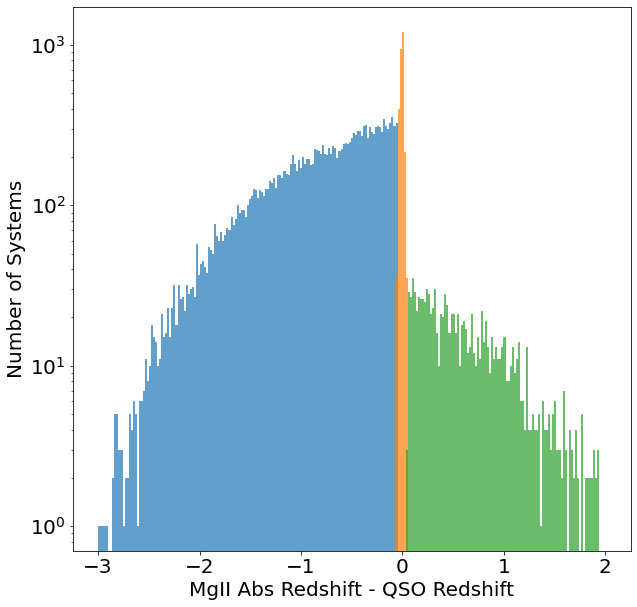

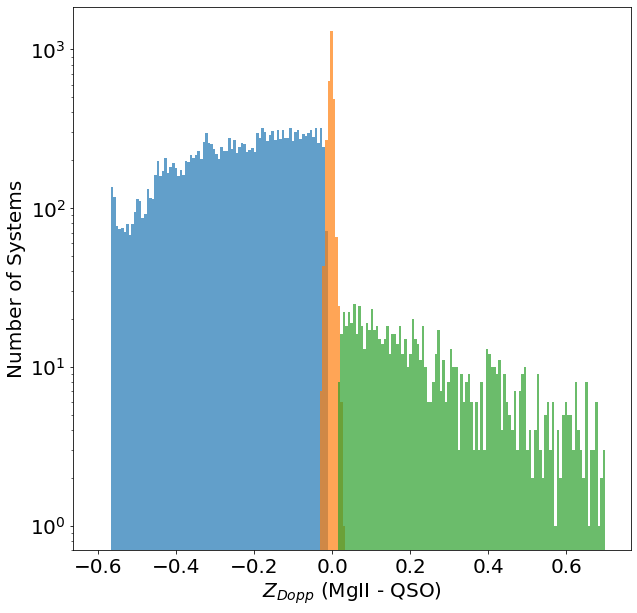

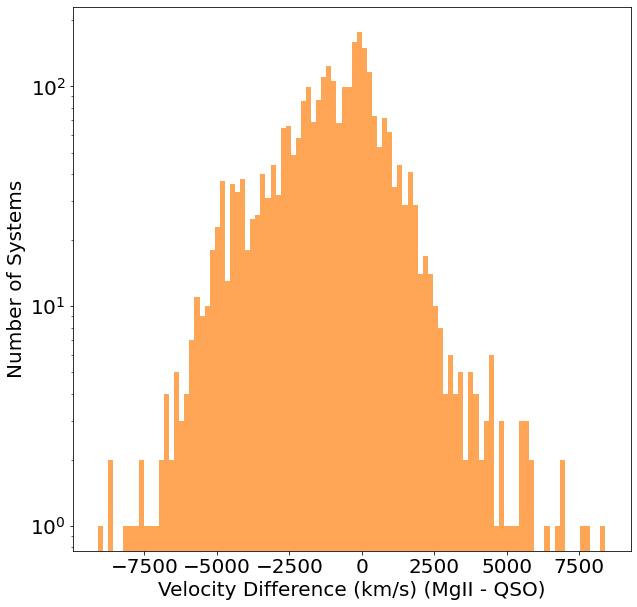

-1029.9981054121463 2020.533160315065


In [41]:
pure_cat=purity_cuts(MgII_cat_full, PIA_cut=False)

pure_cat_INT=pure_cat[(pure_cat['Z_MGII']+0.05<pure_cat['Z_QSO'])]
pure_cat_ASC=pure_cat[np.abs(pure_cat['Z_MGII']-pure_cat['Z_QSO'])<0.05]
pure_cat_PIA=pure_cat[(pure_cat['Z_MGII']>0.05+pure_cat['Z_QSO'])]

bins=np.linspace(-3,2,250)

plt.figure(figsize=(10,10))
plt.hist(pure_cat_INT['Z_MGII']-pure_cat_INT['Z_QSO'],bins=bins,label='Intervening Systems',alpha=0.7)
plt.hist(pure_cat_ASC['Z_MGII']-pure_cat_ASC['Z_QSO'],bins=bins,label='Associated Systems',alpha=0.7)
plt.hist(pure_cat_PIA['Z_MGII']-pure_cat_PIA['Z_QSO'],bins=bins,label='Physically Impossible Systems',alpha=0.7)
plt.yscale('log')
plt.xlabel('MgII Abs Redshift - QSO Redshift')
plt.ylabel('Number of Systems')
#plt.legend()
plt.show()

c=1

INT_zdop=c*(pure_cat_INT['Z_MGII']-pure_cat_INT['Z_QSO'])/(1+pure_cat_INT['Z_QSO'])
ASC_zdop=c*(pure_cat_ASC['Z_MGII']-pure_cat_ASC['Z_QSO'])/(1+pure_cat_ASC['Z_QSO'])
PIA_zdop=c*(pure_cat_PIA['Z_MGII']-pure_cat_PIA['Z_QSO'])/(1+pure_cat_PIA['Z_QSO'])

v_bins=np.linspace(-0.6,0.7,200)

plt.figure(figsize=(10,10))
plt.hist(INT_zdop,bins=v_bins,alpha=0.7)
plt.hist(ASC_zdop,bins=v_bins,alpha=0.7)
plt.hist(PIA_zdop,bins=v_bins,alpha=0.7)
plt.yscale('log')
plt.xlabel('$Z_{Dopp}$ (MgII - QSO)')
plt.ylabel('Number of Systems')
plt.show()

plt.figure(figsize=(10,10))

plt.hist(300000*ASC_zdop,alpha=0.7,bins=100,color='C01')

plt.yscale('log')
plt.xlabel('Velocity Difference (km/s) (MgII - QSO)')
plt.ylabel('Number of Systems')
plt.show()

print(np.mean(300000*ASC_zdop),np.std(300000*ASC_zdop))

In [4]:
#These pased as command line args
redux='guadalupe'
reduction_base_dir='/global/cfs/cdirs/desi/spectro/redux/{}/'.format(redux)

#open catalog
QSOcat_fp='/global/cfs/cdirs/desi/users/edmondc/QSO_catalog/{}/QSO_cat_{}_healpix.fits'.format(redux,redux)
QSOcat=fitsio.read(QSOcat_fp,'QSO_CAT')

#restrict to only dark time exposures (??)
QSOcat = QSOcat[QSOcat['PROGRAM'] == 'dark']

#create list of unique healpix values
hp_vals=radec2pix(64,QSOcat['TARGET_RA'],QSOcat['TARGET_DEC'])
hp_unique=np.unique(hp_vals)

#routine to check if hp values have been completed
#make a mask of healpix directories that have/have not been succesfully complete    
hp_complete_mask=[]

for hp_val in hp_unique:
    #recast as str
    hp_str=str(hp_val)

    #format filepath to MgII output
    out_dir='/global/cscratch1/sd/lucasnap/MgII_Abs_Chains/{}/{}/{}'.format(redux,hp_str[0:-2],hp_str)
    h5_fn='MgII-Abs-Chains-{}.hdf5'.format(hp_str)
    h5_fp=os.path.join(out_dir,h5_fn)

    #see if a valid h5 file is written into path (TODO: a way to do this without try/except?)
    try:
        f=h5py.File(h5_fp,'r')
        #if it is (i.e. no error thrown) we have completed this hp_val (mask[val]=True)
        hp_complete_mask.append(True)
    #if a valid h5 file hasn't been written. we can check if it exists and remove it, then proceed. Either way (mask[val]=False)
    except OSError as e:
        if(str(e)[0:19]=='Unable to open file' and os.path.exists(h5_fp)):
            os.remove(h5_fp)
        hp_complete_mask.append(False)

#np-ify (TODO: better way to do this?)
hp_complete_mask=np.asarray(hp_complete_mask)

#find subset of incomplete hp_dirs
hp_incomplete=hp_unique[~hp_complete_mask]
print(len(hp_incomplete))

0
